In [1]:
# -*- coding: utf-8 -*-
"""
@author: martin.bachmann@dlr.de
"""

import numpy as np
#from osgeo import gdal
#from gdalconst import *
import scipy as scipy
from scipy import linalg, optimize  

from scipy.optimize import curve_fit

from scipy import signal

# for the majority filter we need:
from scipy.ndimage.filters import generic_filter
from scipy.stats import mode


import sys
from sys import stdout

import time
import pandas as pd
import spectral.io.envi as envi

from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error 
from sklearn.model_selection import cross_val_predict, train_test_split 
from sklearn.linear_model import LinearRegression



import matplotlib.pyplot as plt
import matplotlib.collections as collections

import seaborn as sns

from scipy.signal import savgol_filter

In [2]:
print("Parts of this code is based on the highly recommended blog:")
print("https://towardsdatascience.com")
print("")      

Parts of this code is based on the highly recommended blog:
https://towardsdatascience.com



In [3]:
print("Within the following, R2 is _NOT_ equal to Pearson R^2")
print("... and it can be negative! ")
print("check https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html")

Within the following, R2 is _NOT_ equal to Pearson R^2
... and it can be negative! 
check https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html


In [5]:
# now read the data:
spectral_lib_path = "C:/Users/bachma_m/Documents/__Jena_2020/Python_J2020/average_4er_good.slb.hdr"

# when using the combination of 2 soil measurments:
#spectral_lib_path = "C:/Users/bachma_m/Documents/__Jena_2020/Python_J2020/speclib_at_avris_res.slb.hdr"

lib_in = envi.open(spectral_lib_path)
    
s_spec = lib_in.spectra
s_names = lib_in.names
s_nspec = s_spec.shape[0]
s_nbnds = s_spec.shape[1]

wavel_in = np.asarray(lib_in.bands.centers)


In [6]:
print("Number of spectra: ", s_nspec)
print("Number of bands: ", s_nbnds)
print("Size of array: ",s_spec.shape)
print("Datatype of array: ", s_spec.dtype)
print("Wavelengths covered: ", np.min(wavel_in), " to ", np.max(wavel_in))
print("Name of first and last spectrum: ", s_names[0], " ", s_names[s_nspec-1])

Number of spectra:  33
Number of bands:  2151
Size of array:  (33, 2151)
Datatype of array:  float64
Wavelengths covered:  350.0  to  2500.0
Name of first and last spectrum:  spectrum #1   spectrum #33


Using matplotlib:


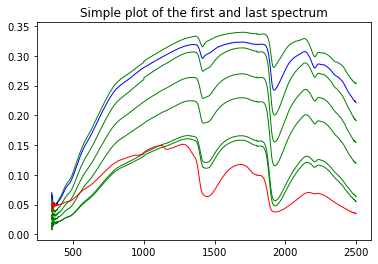

In [11]:
print("Using matplotlib:")
plt.figure()
plt.plot(wavel_in, s_spec[0,:], color='green', linewidth=1, label=s_names[0])
plt.plot(wavel_in, s_spec[2,:], color='blue', linewidth=1, label=s_names[0])
plt.plot(wavel_in, s_spec[4,:], color='green', linewidth=1, label=s_names[0])
plt.plot(wavel_in, s_spec[6,:], color='green', linewidth=1, label=s_names[0])
plt.plot(wavel_in, s_spec[8,:], color='green', linewidth=1, label=s_names[0])
plt.plot(wavel_in, s_spec[14,:], color='green', linewidth=1, label=s_names[0])
plt.plot(wavel_in, s_spec[16,:], color='green', linewidth=1, label=s_names[0])
plt.plot(wavel_in, s_spec[s_nspec-1,:], color='red', linewidth=1, label=s_names[s_nspec-1])
#plt.legend(loc="lower right")
plt.title('Simple plot of the first and last spectrum')
plt.show()

In [7]:
# and get the "lab" references for this:

# when using just one soil sample:
water = np.asarray([0., 1,2,3,6,9,12,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,105,110,120,130,140,150,160,170])


# in case of the 2 combined soil measurment
#water = np.asarray([0., 1,2,3,6,9,12,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,105,110,120,130,140,150,160,170, 0,1,2,3,4,5,6,7,9,11,13,15,17,18,21,23,25,27,29,31])


water1 = water
water2 = water


Using matplotlib:


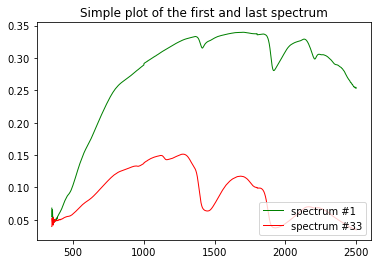

 
And now using Seaborn and Pandas:
Plotting the data distribution within band 100:


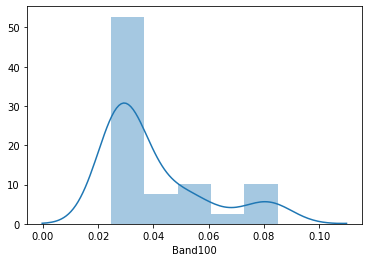

Box plot for band 100:


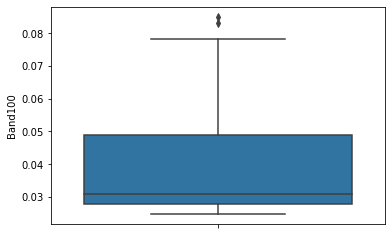

... and adding data points to it:


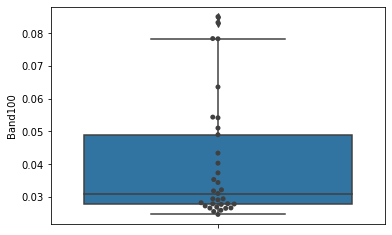

Now the correlation of band 100 and band 1500:
And now visualize if there's already a correlation with the water content:


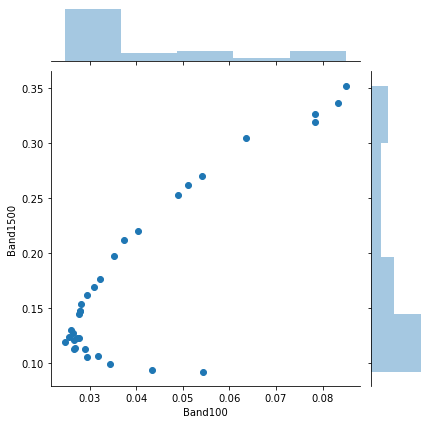

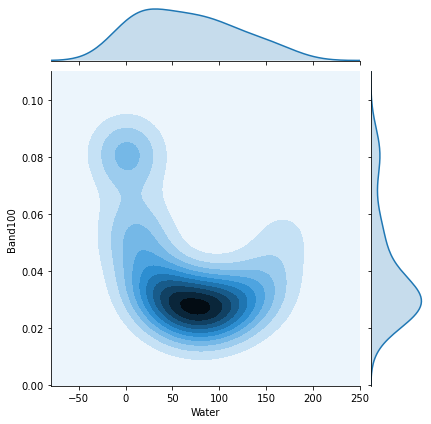

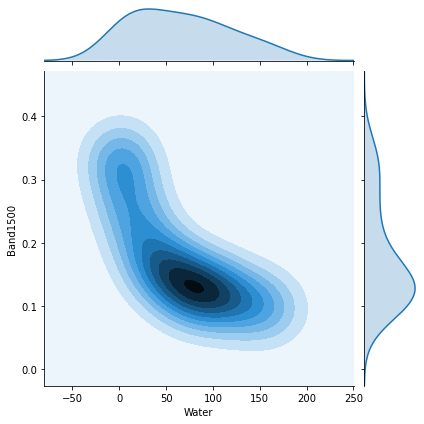

In [8]:

# maybe some visualizations first:

print("Using matplotlib:")
plt.figure()
plt.plot(wavel_in, s_spec[0,:], color='green', linewidth=1, label=s_names[0])
plt.plot(wavel_in, s_spec[s_nspec-1,:], color='red', linewidth=1, label=s_names[s_nspec-1])
plt.legend(loc="lower right")
plt.title('Simple plot of the first and last spectrum')
plt.show()

print(" ")
print("And now using Seaborn and Pandas:")

# just for fun create a Pandas Dataframe                       
                       
                        
dataset = pd.DataFrame({'Water': water, 'Band100': s_spec[:,100], 'Band1500': s_spec[:,1500]})


             
#fig, ax = plt.subplots(nrows=1, ncols=2,  sharex=False, sharey=False)

# so that we can use the nice plottings:

print("Plotting the data distribution within band 100:")
sns.distplot(dataset["Band100"]);
plt.show()


print("Box plot for band 100:")
# now as boxplots
#ax = sns.boxplot(dataset["Band1500"]);
#plt.show()
sns.boxplot(y=dataset["Band100"]);
plt.show()


print("... and adding data points to it:")
sns.boxplot(y=dataset["Band100"]);
sns.swarmplot(y=dataset["Band100"], color=".25");
plt.show()



print("Now the correlation of band 100 and band 1500:")
# correlation between band 100 (450 nm) and band 1500 (1850 nm)
sns.jointplot(x="Band100", y="Band1500", data=dataset);   

# and already with the water content:
print("And now visualize if there's already a correlation with the water content:")
sns.jointplot(x="Water", y="Band100", data=dataset, kind="kde");
sns.jointplot(x="Water", y="Band1500", data=dataset, kind="kde");                        
    

    
    
    


In [18]:
####################################################################################################################################################################################################################
# now for the linear regression:

# source:
# https://towardsdatascience.com/a-beginners-guide-to-linear-regression-in-python-with-scikit-learn-83a8f7ae2b4f


# first a simple linear thing... using one feature only, here it's rho in band 500:
spec = s_spec[:,1200] #500 #CHANGEME #1500

# next for the fitting to work, we need to reshape it: 
spec = spec.reshape(-1,1)

# next we start the linear model:
mylin = LinearRegression(fit_intercept=True)

# and do the fitting...
mylin.fit(spec, water)

print('Intercept : ',mylin.intercept_)
print('Gain coeff: ',mylin.coef_)


# now the predicted water
water_linpred = mylin.predict(spec)

#print('Hier das gemessene Wasser:')
#print(water)
#print('Und hier das vom Modell auf Bais des Bands 500 vorhergesagte:')
#print(water_linpred)


print('R2 :',r2_score(water, water_linpred))
print('Mean Absolute Error:', mean_absolute_error(water, water_linpred))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(water, water_linpred)) )
print('Mean Squared Error:', mean_squared_error(water, water_linpred))  


# and do the 10-fold cross-validation
water_lin_crossval = cross_val_predict(mylin, spec, water, cv=10) # cross-val
mse_lin_crossval = mean_squared_error(water, water_lin_crossval) # mean error for cross-val
# whatever =   r2_score(water, o_water_predicted) # <= IF R2 would be better
print('MSE cross-val: %5.3f' % mse_lin_crossval) 

Intercept :  162.39803380572394
Gain coeff:  [-551.43684847]
Hier das gemessene Wasser:
[  0.   1.   2.   3.   6.   9.  12.  15.  20.  25.  30.  35.  40.  45.
  50.  55.  60.  65.  70.  75.  80.  85.  90.  95. 100. 105. 110. 120.
 130. 140. 150. 160. 170.]
Und hier das vom Modell auf Bais des Bands 500 vorhergesagte:
[-22.29753389 -30.69097866 -12.60075828 -18.13285389  -4.57574546
  14.96590987  20.13689904  24.88792714  42.90667563  47.57452253
  55.56981839  66.52643202  70.19053142  74.58658504  78.80054885
  82.01818926  83.37817461  81.93086668  91.79818202  97.28236607
  94.37263802  92.50009573  95.90720075  94.71834367  94.44352959
  99.49933935 100.28903066 100.1827801  104.57083134 103.90061388
 107.41503562 110.14722918 110.79757372]
R2 : 0.7464727187515423
Mean Absolute Error: 21.47476139849599
Root Mean Squared Error: 25.16934638902569
Mean Squared Error: 633.4959976507605
MSE cross-val: 1190.831


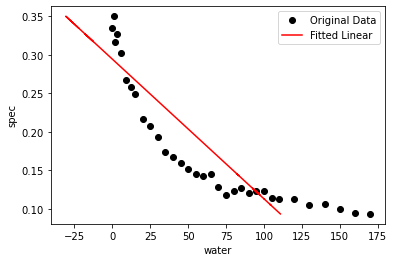

In [19]:
plt.figure()
plt.plot(water, spec, 'ko', label="Original Data")
plt.plot(water_linpred, spec ,'r-', label="Fitted Linear")
plt.xlabel('water')
plt.ylabel('spec')
plt.legend()
plt.show()


Intercept :  80.13764648858296
Gain coeff of the 4 features:  [ -4242.99309318   9117.74665198 -12568.31793438   4710.11653068]
R2: 0.9893755717917058
Mean Absolute Error: 4.305641035048352
Root Mean Squared Error: 5.152433214847396
Mean Squared Error: 26.547568033462678
=> R2 von 0.9.... super!
MSE cross-val: 157.252
=> Modell ist nach Cross-Val noch schlechter!


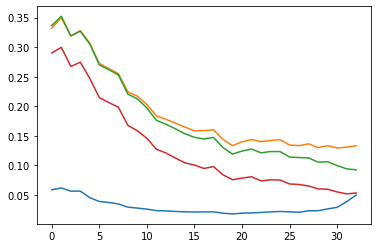

In [22]:
#######################################################################################################################################

# let's check for a multiple linear regression now...

#specmulti = np.zeros((53,4))   # create an array with 4 features... #  OLD 33,4 CHANGEME

specmulti = np.zeros((33,4))   # create an array with 4 features... #  OLD 33,4 CHANGEME
specmulti[:,0]=s_spec[:,50]   # and fill it with bands 500, 1000, 1500, 2000 for now  CHANGEME
specmulti[:,1]=s_spec[:,1000]
specmulti[:,2]=s_spec[:,1500]
specmulti[:,3]=s_spec[:,2000]

#plt.plot(specmulti)


mylinmulti = LinearRegression(fit_intercept=True)

mylinmulti.fit(specmulti, water)

print('Intercept : ',mylinmulti.intercept_)
print('Gain coeff of the 4 features: ',mylinmulti.coef_)

water_multipred = mylinmulti.predict(specmulti)


print('R2:',r2_score(water, water_multipred))
print('Mean Absolute Error:', mean_absolute_error(water, water_multipred))  
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(water, water_multipred)) )
print('Mean Squared Error:', mean_squared_error(water, water_multipred))  

print("=> R2 von 0.9.... super!")

# and do the 10-fold cross-validation
water_linmulti_crossval = cross_val_predict(mylinmulti, specmulti, water, cv=10) # cross-val
mse_linmulti_crossval = mean_squared_error(water, water_linmulti_crossval) # mean error for cross-val
# whatever =   r2_score(water, o_water_predicted) # <= IF R2 would be better
print('MSE cross-val: %5.3f' % mse_linmulti_crossval)

print("=> Modell ist nach Cross-Val noch schlechter!")

1st coeff:  [-550.00834306  162.96254927]
R2: 0.7561980735390414
Mean Squared Error: 609.1949705452137


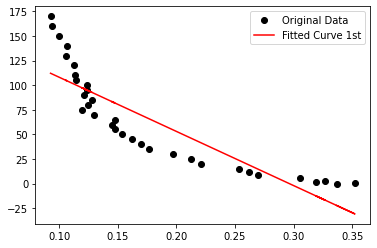

2nd coeff:  [ 4244.35111559 -2369.50191027   325.74111116]
R2: 0.9315889213391378
Mean Squared Error: 170.94075364676823


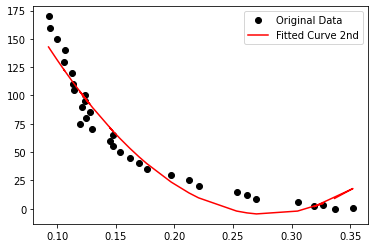

In [25]:
#######################################################################################################################################

# now fitting a ploynomial:

spec = s_spec[:,1500] #changeme 500  #1500

# first a 1st degree:
curve_fit_1st = np.polyfit(spec, water, 1)
print('1st coeff: ', curve_fit_1st)
water_pred_1st = curve_fit_1st[0] * spec + curve_fit_1st[1]
print('R2:',r2_score(water, water_pred_1st))
print('Mean Squared Error:', mean_squared_error(water, water_pred_1st)) 

#plt.plot(spec, water, "o")
#plt.plot(spec, water_pred_1st)
plt.figure()
plt.plot(spec, water, 'ko', label="Original Data")
plt.plot(spec, water_pred_1st, 'r-', label="Fitted Curve 1st")
plt.legend()
plt.show()


curve_fit_2nd = np.polyfit(spec, water, 2)
print('2nd coeff: ', curve_fit_2nd)
water_pred_2nd = curve_fit_2nd[0] * spec*spec + curve_fit_2nd[1] * spec+ curve_fit_2nd[2]
print('R2:',r2_score(water, water_pred_2nd))
print('Mean Squared Error:', mean_squared_error(water, water_pred_2nd)) 

#plt.plot(spec, water, "o")
#plt.plot(spec, water_pred_2nd)

plt.figure()
plt.plot(spec, water, 'ko', label="Original Data")
plt.plot(spec, water_pred_2nd, 'r-', label="Fitted Curve 2nd")
plt.legend()
plt.show()

Lin. model a*x+b with:  -550.0083433739175 162.96254932595602
  R2: 0.7561980735390413
  Mean Squared Error: 609.194970545214


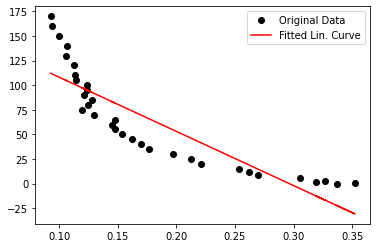

Lin. model a*x with:  215.69803964151106
  R2: -0.999429338291697
  Mean Squared Error: 4996.032289527044


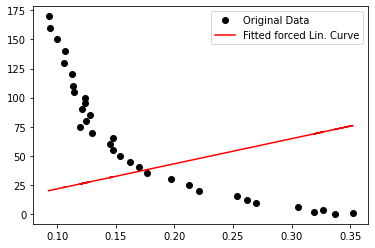

Quadratic model a*x^2 + b*x + c  with:  4244.351136229518 -2369.501919297563 325.7411119871164
  R2: 0.9315889213391377
  Mean Squared Error: 170.94075364676846


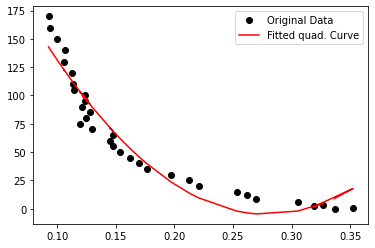

<ipython-input-26-ad56ebba1e49>:35: RuntimeWarning: invalid value encountered in log
  return a * np.log(b * x) + c    # ??? -b or b


Log model a* log(b*x) + c with:  -113.91591098679292 4.973390913698083 41.08180441851033
  R2: 0.8696300686080847
  Mean Squared Error: 325.75914254310646


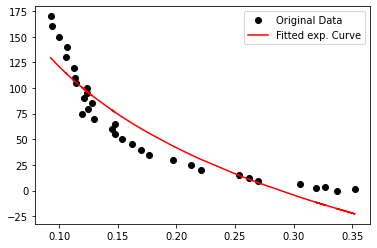

C:\Users\bachma_m\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Exponential model a* exp(-b*x) + c with:  104.36512060029608 570.256328374051 65.2424241287677
  R2: 2.220446049250313e-16
  Mean Squared Error: 2498.729109274564


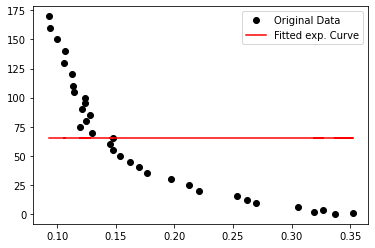

In [26]:
#######################################################################################################################################

# and now any curve, e.g. an exponential:

# the following doesn't describe the ZUSAMMENHANG, thus no solution found:
#def funca(x, a, b, c):
#    return a * np.exp(-b * x) + c
#
#popt, pcov = curve_fit(funca, spec, water)
#water_pred_exp1 = funca(spec, *popt)
#
#
#plt.figure()
#plt.plot(spec, water, 'ko', label="Original Data")
#plt.plot(spec, funca(spec, *popt), 'r-', label="Fitted Curve")
#plt.legend()
#plt.show()

#################### Here are the function definitions linear, quad, expon, loga:
#

def flin(x,a,b):
    return a*x + b

def fforce(x,a):   # muss durch Ursprung gehen
    return a*x

def fquad(x,a,b,c):
    return a* x**2 + b * x + c

def fexp(x, a,b,c):
    return a * np.exp(-b * x) + c   # ??? -b or b

def flog(x, a,b,c):
    return a * np.log(b * x) + c    # ??? -b or b 


popt2, pcov2 = curve_fit(flin, spec, water)
water_pred_exp2 = flin(spec, *popt2)
print('Lin. model a*x+b with: ',*popt2)
print('  R2:',r2_score(water, water_pred_exp2))
print('  Mean Squared Error:', mean_squared_error(water, water_pred_exp2))

plt.figure()
plt.plot(spec, water, 'ko', label="Original Data")
plt.plot(spec, flin(spec, *popt2), 'r-', label="Fitted Lin. Curve")
plt.legend()
plt.show()


popt2, pcov2 = curve_fit(fforce, spec, water)
water_pred_exp2 = fforce(spec, *popt2)
print('Lin. model a*x with: ',*popt2)
print('  R2:',r2_score(water, water_pred_exp2))
print('  Mean Squared Error:', mean_squared_error(water, water_pred_exp2))

plt.figure()
plt.plot(spec, water, 'ko', label="Original Data")
plt.plot(spec, fforce(spec, *popt2), 'r-', label="Fitted forced Lin. Curve")
plt.legend()
plt.show()


popt2, pcov2 = curve_fit(fquad, spec, water)
water_pred_exp2 = fquad(spec, *popt2)
print('Quadratic model a*x^2 + b*x + c  with: ',*popt2)
print('  R2:',r2_score(water, water_pred_exp2))
print('  Mean Squared Error:', mean_squared_error(water, water_pred_exp2))

plt.figure()
plt.plot(spec, water, 'ko', label="Original Data")
plt.plot(spec, fquad(spec, *popt2), 'r-', label="Fitted quad. Curve")
plt.legend()
plt.show()

popt2, pcov2 = curve_fit(flog, spec, water)
water_pred_exp2 = flog(spec, *popt2)
print('Log model a* log(b*x) + c with: ',*popt2)
print('  R2:',r2_score(water, water_pred_exp2))
print('  Mean Squared Error:', mean_squared_error(water, water_pred_exp2))

plt.figure()
plt.plot(spec, water, 'ko', label="Original Data")
plt.plot(spec, flog(spec, *popt2), 'r-', label="Fitted exp. Curve")
plt.legend()
plt.show()



popt2, pcov2 = curve_fit(fexp, spec, water)
water_pred_exp2 = fexp(spec, *popt2)
print('Exponential model a* exp(-b*x) + c with: ',*popt2)
print('  R2:',r2_score(water, water_pred_exp2))
print('  Mean Squared Error:', mean_squared_error(water, water_pred_exp2))

plt.figure()
plt.plot(spec, water, 'ko', label="Original Data")
plt.plot(spec, fexp(spec, *popt2), 'r-', label="Fitted exp. Curve")
plt.legend()
plt.show()


    
    
    

Exp. model a*exp(b*x)+c) with:  1113.9832602227204 -20.748492810844088 4.791378118178565
  R2: 0.9827232983927213
  Mean Squared Error: 43.169797218357886


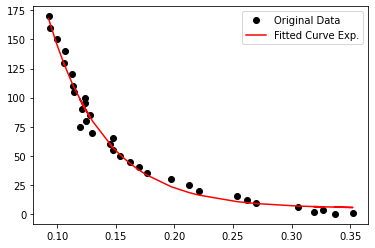

In [27]:

##### now we got the exp_b instead of exp_-b model:

def funcb(x, a, b, c):
    return a * np.exp(b * x) + c



popt2, pcov2 = curve_fit(funcb, spec, water)
water_pred_exp2 = funcb(spec, *popt2)
print('Exp. model a*exp(b*x)+c) with: ',*popt2)
print('  R2:',r2_score(water, water_pred_exp2))
print('  Mean Squared Error:', mean_squared_error(water, water_pred_exp2))

plt.figure()
plt.plot(spec, water, 'ko', label="Original Data")
plt.plot(spec, funcb(spec, *popt2), 'r-', label="Fitted Curve Exp.")
plt.legend()
plt.show()

In [28]:
print(' ')
print("----- Now we're using the PLS -----")
print(' ')

# Define PLS object
pls = PLSRegression(n_components=5)

# predictor X => spectra
# response  Y => water content

# Fit
pls.fit(s_spec, water)

# get the R2 of the prediction
pls.score(s_spec, water)

# estimate the predicted water for each spectrum:
dummy = pls.predict(s_spec)
water_predicted = dummy[:,0]



 
----- Now we're using the PLS -----
 


spectra & 5 components (score, mse):  0.8953237828143421 261.5575109305498


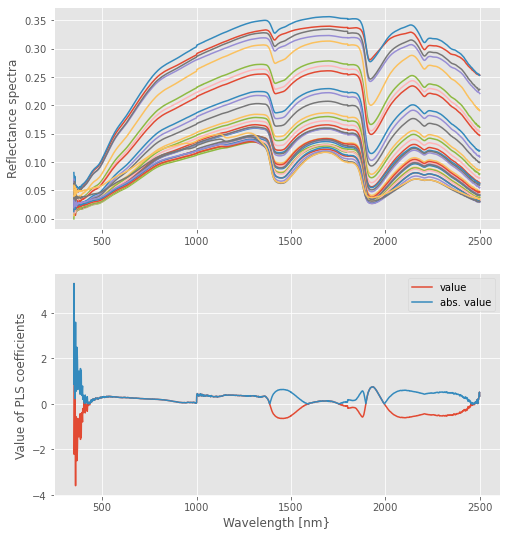

In [29]:
# Cross-validation
water_cv = cross_val_predict(pls, s_spec, water, cv=10)

# Calculate scores
score = r2_score(water, water_cv)
mse = mean_squared_error(water, water_cv)

print("spectra & 5 components (score, mse): ", score, mse )

# Plot spectra
plt.figure(figsize=(8,9))
with plt.style.context(('ggplot')):
    ax1 = plt.subplot(211)
    plt.plot(wavel_in, s_spec.T)
    plt.ylabel('Reflectance spectra')
    #ax2 = plt.subplot(212, sharex=ax1)
    #plt.plot(wavel_in, np.abs(pls.coef_[:,0]))
    #plt.xlabel('Wavelength (nm)')
    #plt.ylabel('Absolute value of PLS coefficients')
    
    ax2 = plt.subplot(212, sharex=ax1)
    plt.plot(wavel_in, pls.coef_[:,0], label='value')
    plt.plot(wavel_in, np.abs(pls.coef_[:,0]), label='abs. value')
    plt.xlabel('Wavelength [nm}')
    plt.ylabel('Value of PLS coefficients')
    plt.legend();
    
    plt.show()

good spectra & 5 components (score, mse):  0.9122531371373443 219.255640482441


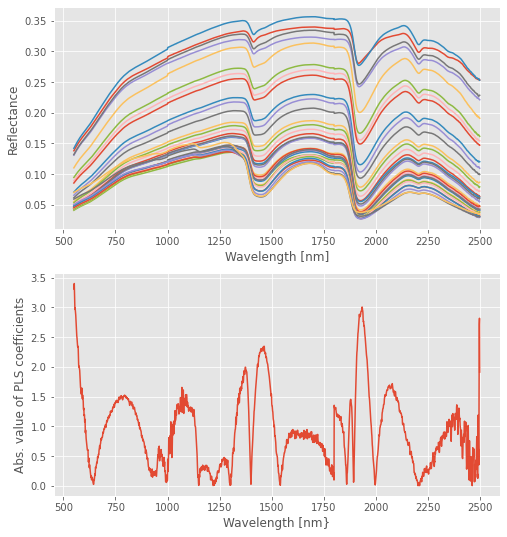

In [41]:
##############################################################################################################################################################################
# => what happens if we discard the first ~200 noisy bands?
    
wavel_good = wavel_in[200:] # changeme OLD 100 
spec_good = s_spec[:,200:]  # changeme OLD 100 


pls_g = PLSRegression(n_components=5)

pls_g.fit(spec_good, water)
water_cv_g = cross_val_predict(pls_g, spec_good, water, cv=10)
score_g = r2_score(water, water_cv_g)
mse_g = mean_squared_error(water, water_cv_g)

print("good spectra & 5 components (score, mse): ", score_g, mse_g )

# Plot spectra
plt.figure(figsize=(8,9))
with plt.style.context(('ggplot')):
    ax1 = plt.subplot(211)
    plt.plot(wavel_good, spec_good.T)
    plt.xlabel('Wavelength [nm]')
    plt.ylabel('Reflectance')

    ax2 = plt.subplot(212, sharex=ax1)
    #plt.plot(wavel_good, pls_g.coef_[:,0], label='value')
    plt.plot(wavel_good, np.abs(pls_g.coef_[:,0]))
    plt.xlabel('Wavelength [nm}')
    plt.ylabel('Abs. value of PLS coefficients')
    #plt.legend();
plt.show()

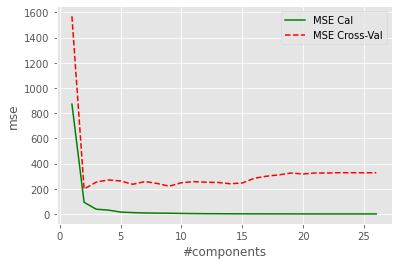

In [32]:
##############################################################################################################################################################################

# Show how the mean error behaves in calibration Vs. validation models when adding components:

n_comp = 27   #was: 30

mse_cal = []
mse_val = []
component = np.arange(1, n_comp)

for i in component:
    pls = PLSRegression(n_components=i)
    
    pls.fit(s_spec, water)
    dummy = pls.predict(s_spec)
    
    
    water_predicted = dummy[:,0]
    water - water_predicted
    mse_cal.append(mean_squared_error(water, water_predicted))

    # Cross-validation
    y_cv = cross_val_predict(pls, s_spec, water, cv=10)
    mse_val.append(mean_squared_error(water, y_cv))
    
  
    
# Plot the scores:
with plt.style.context(('ggplot')):
    plt.plot(component,mse_cal, '-g', label='MSE Cal')
    plt.plot(component,mse_val, '--r', label='MSE Cross-Val')
    plt.xlabel('#components')
    plt.ylabel('mse')
    plt.legend();
plt.show()  

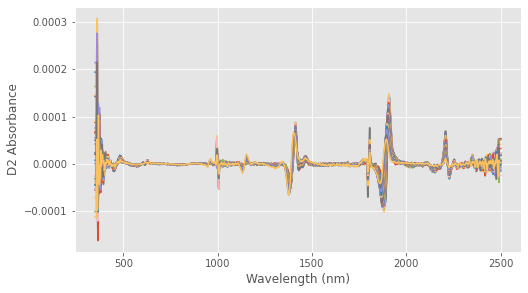

1st derivative & 5 components (score1, mse1):  0.9305727701625398 173.47984017115743
2nd derivative & 5 components (score2, mse2):  0.9445422043607604 138.57400829996797


In [42]:
# for derivatives_
s_spec1  = savgol_filter(s_spec, 17, polyorder = 2,deriv=1)
s_spec2  = savgol_filter(s_spec, 17, polyorder = 2,deriv=2)

# Plot second derivative
plt.figure(figsize=(8,4.5))
with plt.style.context(('ggplot')):
    plt.plot(wavel_in, s_spec2.T)
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('D2 Absorbance')
    plt.show()


pls1 = PLSRegression(n_components=5)
pls1.fit(s_spec1, water1)
water_cv1 = cross_val_predict(pls1, s_spec1, water1, cv=10)
score1 = r2_score(water1, water_cv1)
mse1 = mean_squared_error(water1, water_cv1)
print("1st derivative & 5 components (score1, mse1): ", score1, mse1 )

pls2 = PLSRegression(n_components=5)
pls2.fit(s_spec2, water2)
water_cv2 = cross_val_predict(pls2, s_spec2, water2, cv=10)
score2 = r2_score(water2, water_cv2)
mse2 = mean_squared_error(water2, water_cv2)
print("2nd derivative & 5 components (score2, mse2): ", score2, mse2 )


Using the reflectances:
67% completed
Suggested number of components:  2



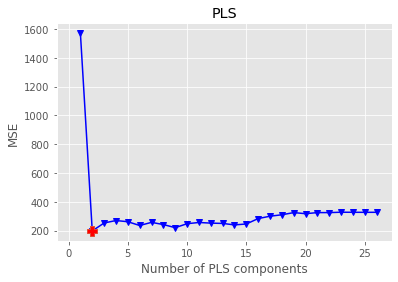

R2 calib: 0.963
R2 CV: 0.921
MSE calib: 92.250
MSE CV: 197.721


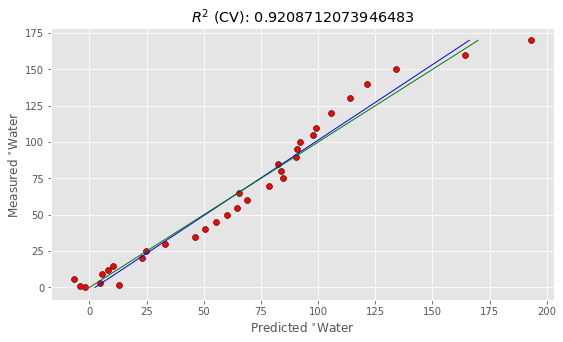


Using 1st derivatives:
40% completed
Suggested number of components:  2



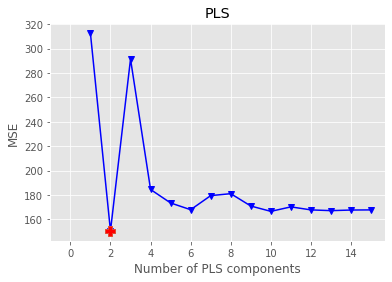

R2 calib: 0.967
R2 CV: 0.940
MSE calib: 81.942
MSE CV: 150.580


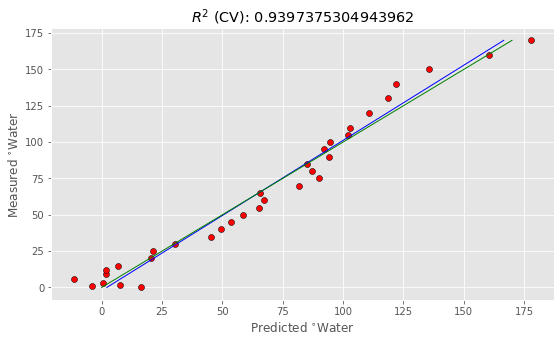


Using 2nd derivatives:
40% completed
Suggested number of components:  2



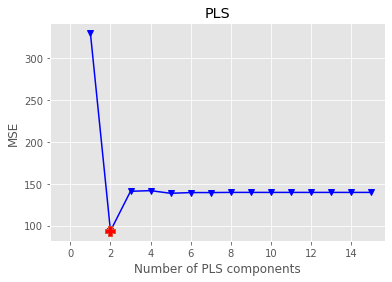

R2 calib: 0.983
R2 CV: 0.963
MSE calib: 41.496
MSE CV: 93.648


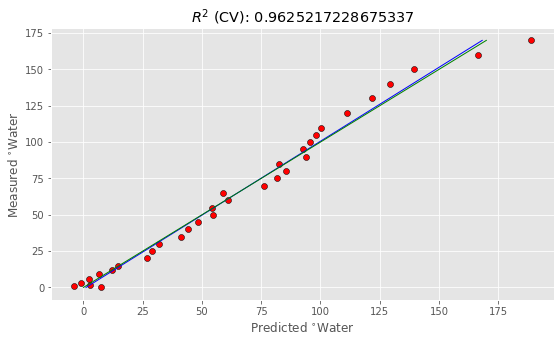

In [43]:
##############################################################################################################################################################################


def optimise_pls_cv(X, y, n_comp, plot_components=True):

    '''Run PLS including a variable number of components, up to n_comp,
       and calculate MSE '''

    mse = []
    component = np.arange(1, n_comp)

    for i in component:
        pls = PLSRegression(n_components=i)

        # Cross-validation
        y_cv = cross_val_predict(pls, X, y, cv=10)

        mse.append(mean_squared_error(y, y_cv))

        comp = 100*(i+1)/40
        # Trick to update status on the same line
        stdout.write("\r%d%% completed" % comp)
        stdout.flush()
    stdout.write("\n")

    # Calculate and print the position of minimum in MSE
    msemin = np.argmin(mse)
    print("Suggested number of components: ", msemin+1)
    stdout.write("\n")

    if plot_components is True:
        with plt.style.context(('ggplot')):
            plt.plot(component, np.array(mse), '-v', color = 'blue', mfc='blue')
            plt.plot(component[msemin], np.array(mse)[msemin], 'P', ms=10, mfc='red')
            plt.xlabel('Number of PLS components')
            plt.ylabel('MSE')
            plt.title('PLS')
            plt.xlim(left=-1)

        plt.show()

    # Define PLS object with optimal number of components
    pls_opt = PLSRegression(n_components=msemin+1)

    # Fir to the entire dataset
    pls_opt.fit(X, y)
    y_c = pls_opt.predict(X)

    # Cross-validation
    y_cv = cross_val_predict(pls_opt, X, y, cv=10)

    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)

    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)

    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)

    # Plot regression and figures of merit
    rangey = max(y) - min(y)
    rangex = max(y_c) - min(y_c)

    # Fit a line to the CV vs response
    z = np.polyfit(y, y_c, 1)
    with plt.style.context(('ggplot')):
        fig, ax = plt.subplots(figsize=(9, 5))
        ax.scatter(y_c, y, c='red', edgecolors='k')
        #Plot the best fit line
        ax.plot(np.polyval(z,y), y, c='blue', linewidth=1)
        #Plot the ideal 1:1 line
        ax.plot(y, y, color='green', linewidth=1)
        plt.title('$R^{2}$ (CV): '+str(score_cv))
        plt.xlabel('Predicted $^{\circ}$Water')
        plt.ylabel('Measured $^{\circ}$Water')

        plt.show()

    return


# now run it_   ### if setting the iterations to ~40, one can demonstrate the error behaviour of the fitting ;)
print('')
print('Using the reflectances:')
optimise_pls_cv(s_spec,water, 27, plot_components=True) #40

print('')
print('Using 1st derivatives:')
optimise_pls_cv(s_spec1,water, 16, plot_components=True) #40

print('')
print('Using 2nd derivatives:')
optimise_pls_cv(s_spec2,water, 16, plot_components=True) #40

In [44]:
##############################################################################################################################################################################

# Now for the feature selection part:

def pls_variable_selection(X, y, max_comp):
    
    # Define MSE array to be populated
    mse = np.zeros((max_comp,X.shape[1]))

    # Loop over the number of PLS components
    for i in range(max_comp):
        
        # Regression with specified number of components, using full spectrum
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(X, y)
        
        # Indices of sort spectra according to ascending absolute value of PLS coefficients
        sorted_ind = np.argsort(np.abs(pls1.coef_[:,0]))

        # Sort spectra accordingly 
        Xc = X[:,sorted_ind]

        # Discard one wavelength at a time of the sorted spectra,
        # regress, and calculate the MSE cross-validation
        for j in range(Xc.shape[1]-(i+1)):

            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
            
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=5)

            mse[i,j] = mean_squared_error(y, y_cv)
    
        comp = 100*(i+1)/(max_comp)
        stdout.write("\r%d%% completed" % comp)
        stdout.flush()
    stdout.write("\n")

    # # Calculate and print the position of minimum in MSE
    mseminx,mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))

    print("Optimised number of PLS components: ", mseminx[0]+1)
    print("Wavelengths to be discarded ",mseminy[0])
    print('Optimised MSEP ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    # plt.imshow(mse, interpolation=None)
    # plt.show()


    # Calculate PLS with optimal components and export values
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(X, y)
        
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))

    Xc = X[:,sorted_ind]

    return(Xc[:,mseminy[0]:],mseminx[0]+1,mseminy[0], sorted_ind)

In [ ]:
##############################################################################################################################################################################

# Now for the feature selection part:

def pls_variable_selection(X, y, max_comp):
    
    # Define MSE array to be populated
    mse = np.zeros((max_comp,X.shape[1]))

    # Loop over the number of PLS components
    for i in range(max_comp):
        
        # Regression with specified number of components, using full spectrum
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(X, y)
        
        # Indices of sort spectra according to ascending absolute value of PLS coefficients
        sorted_ind = np.argsort(np.abs(pls1.coef_[:,0]))

        # Sort spectra accordingly 
        Xc = X[:,sorted_ind]

        # Discard one wavelength at a time of the sorted spectra,
        # regress, and calculate the MSE cross-validation
        for j in range(Xc.shape[1]-(i+1)):

            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
            
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=5)

            mse[i,j] = mean_squared_error(y, y_cv)
    
        comp = 100*(i+1)/(max_comp)
        stdout.write("\r%d%% completed" % comp)
        stdout.flush()
    stdout.write("\n")

    # # Calculate and print the position of minimum in MSE
    mseminx,mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))

    print("Optimised number of PLS components: ", mseminx[0]+1)
    print("Wavelengths to be discarded ",mseminy[0])
    print('Optimised MSEP ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    
    #plt.imshow(mse, interpolation=None)
    #plt.show()


    # Calculate PLS with optimal components and export values
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(X, y)
        
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))

    Xc = X[:,sorted_ind]

    return(Xc[:,mseminy[0]:],mseminx[0]+1,mseminy[0], sorted_ind)

In [45]:
##############################################
# now showing the results form band selection:
##############################################
    
# so first run PLS without optimization: 

wo_pls = PLSRegression(n_components=5)
wo_pls.fit(s_spec, water)
wo_water_predicted = wo_pls.predict(s_spec) #calculate the predicted values
wo_water_crossval = cross_val_predict(wo_pls, s_spec, water, cv=10) # cross-val

wo_mse_pred     = mean_squared_error(water, wo_water_predicted) # mean error for prediction
wo_mse_crossval = mean_squared_error(water, wo_water_crossval) # mean error for cross-val
# whatever =   r2_score(water, o_water_predicted) # <= IF R2 would be better
    
print('Without band selection and 5 components:')
print('   MSE cal      : %5.3f' % wo_mse_pred)
print('   MSE cross-val: %5.3f' % wo_mse_crossval)

print('_______________________________________________________________________')
print('... now starting the variable selection, this may take a lot of time...')


# then optimize the wavelengths selection...    
opt_spec, ncomp, wav, sorted_index = pls_variable_selection(s_spec,water, 15)

print('Optimizing bands - excluding ', wav, ' bands')
print(' Before: ', s_spec.shape[1])
print(' After : ', opt_spec.shape[1])

a = 10

   

# and now the comparison between the running the PLS on full data and on the wavelengths-optimized:

o_pls = PLSRegression(n_components=ncomp)
o_pls.fit(opt_spec, water)
o_water_predicted = o_pls.predict(opt_spec) #calculate the predicted values
o_water_crossval = cross_val_predict(o_pls, opt_spec, water, cv=10) # cross-val

o_mse_pred     = mean_squared_error(water, o_water_predicted) # mean error for prediction
o_mse_crossval = mean_squared_error(water, o_water_crossval) # mean error for cross-val
# whatever =   r2_score(water, o_water_predicted) # <= IF R2 would be better
    


print('With band selection and ', ncomp, ' components:')
print('   MSE cal      : %5.3f' % o_mse_pred)
print('   MSE cross-val: %5.3f' % o_mse_crossval)


Without band selection and 5 components:
   MSE cal      : 14.498
   MSE cross-val: 261.558
_______________________________________________________________________
... now starting the variable selection, this may take a lot of time...
100% completed
Optimised number of PLS components:  6
Wavelengths to be discarded  1417
Optimised MSEP  56.86182902935725

Optimizing bands - excluding  1417  bands
 Before:  2151
 After :  734
With band selection and  6  components:
   MSE cal      : 9.975
   MSE cross-val: 98.420


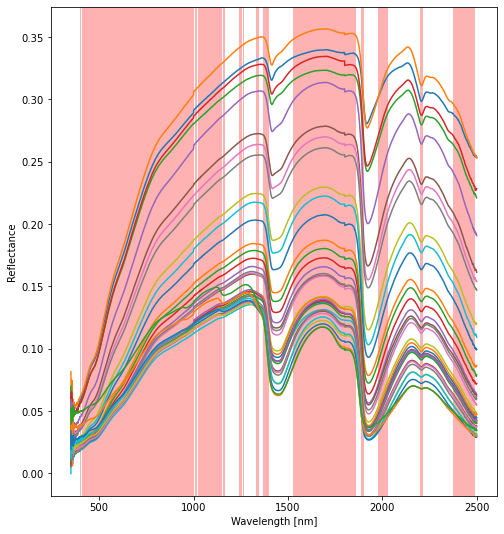

In [46]:
#############
# plot of discared bands:

# opt_Xc,   ncomp, wav,       sorted_ind = pls_variable_selection(X1, y, 15)
# opt_spec, ncomp, wavel_in, sorted_index = pls_variable_selection(s_spec,water, 15


# Get a boolean array according to the indices that are being discarded
ix = np.in1d(wavel_in.ravel(), wavel_in[sorted_index][:wav])


# Plot spectra with superimpose selected bands
fig, ax = plt.subplots(figsize=(8,9))
with plt.style.context(('ggplot')):
    ax.plot(wavel_in, s_spec.T)
    plt.ylabel('Reflectance')
    plt.xlabel('Wavelength [nm]')

collection = collections.BrokenBarHCollection.span_where(
    wavel_in, ymin=-1, ymax=1, where=ix == True, facecolor='red', alpha=0.3)
ax.add_collection(collection)

plt.show()